In [3]:
import os, sys, re, cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import scipy
from PIL import Image
import matplotlib.backends.backend_pdf
from scipy.spatial import distance_matrix


from scipy.signal import correlate2d, fftconvolve
from numpy import flip, arange, reshape
from matplotlib.patches import Rectangle
from scipy import ndimage
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN
plt.rcParams['image.cmap'] = 'gray'
from render2D import grid2D
from scipy.ndimage import maximum_filter
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import pointpats

from utils import *

In [ ]:
soma = cv2.imread("../data/rendered/soma/1226_5.png")
plt.figure(figsize=[10,10])
plt.imshow(soma[700:1500,1000:1900])
#soma

# Functions

## Preprocess the image to localizations

In [ ]:
def adapt_cluster(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    local = 3
    th=cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local, 0)
    contours,_ = cv2.findContours(th,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_centers = np.zeros([len(contours),2])
    for i in range(len(contours)):
        contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)
    
    plt.figure(figsize=[20,20])
    plt.imshow(img)
    plt.plot(
        contour_centers[:, 0],
        contour_centers[:, 1],
        ".",
        markerfacecolor="purple",
        markersize=10,
    )
    return contour_centers

def autocontrast(img, thre=5):
    '''
    img is a one-channel image
    thre in 0-100
    '''
    up = np.percentile(img,100-thre)
    low = np.percentile(img,thre)
    #print(up, low)
    img = 255*(img-low)/(up-low)
    img[img>255]=255
    img[img<0]=0
    return img.astype(np.uint8)

def lmax_loc(loc_file, regions, rimg, adapt=55, local=7, plot=0, verbose=0, sm=4):
    if loc_file is not None:
        smlm=pd.read_table(loc_file,header=0)
        test=smlm[["Xc","Yc","Zc"]]
        img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)

        xc=test["Xc"].tolist()
        yc=test["Yc"].tolist()
        xc=np.array([ int(x*10-regions[0]) for x in xc]).astype(np.int32)-5
        yc=np.array([ int(x*10-regions[2]) for x in yc]).astype(np.int32)-5
        img=grid2D(img,xc,yc,regions[1]-regions[0], regions[3]-regions[2],len(xc))
        img=np.array(img)
    else:
        if len(rimg.shape)==3:
            img=cv2.cvtColor(rimg, cv2.COLOR_BGR2GRAY)
        img=rimg.T
    plt.figure(figsize=[20,20])
    blur=autocontrast(img.T)
    blur=cv2.blur(blur,(4,4))
    #blur=fftconvolve(img.T,cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3)), mode='same')
    #blur=(255*blur/np.max(blur)).astype(np.uint8)
    th=cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, adapt, 0)
    #th1=cv2.threshold(blur.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # filter out the small ones
    kernel=np.ones([sm,sm])
    th1=cv2.erode(th,kernel)
    th2=cv2.dilate(th1,kernel)
    lmax = blur*(blur == maximum_filter(blur, footprint=np.ones((local,local))))
    #plt.figure(figsize=[20,20])
    #plt.imshow(th)
    #cell_mask = getCellMask(blur)
    contours,_ = cv2.findContours(lmax.astype(np.uint8)&th2,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_centers = np.zeros([len(contours),2])
    for i in range(len(contours)):
        contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)

    if plot==1:
        plt.figure(figsize=[20,20])
        #plt.imshow(blur)
        plt.imshow(rimg)
        plt.plot(
            contour_centers[:, 0],
            contour_centers[:, 1],
            ".",
            markerfacecolor="purple",
            markersize=10,
        )
    if verbose==1:
        plt.figure()
        plt.subplots(2,3)
        i=0
        for timg in [img.T, blur, th, th1, th2, lmax]:
            i+=1
            plt.subplot(2,3,i)
            plt.imshow(timg)
    # plt.figure(figsize=[20,20])
    # #plt.imshow(blur)
    # plt.imshow(img.T)
    # plt.plot(
    #     contour_centers[:, 0],
    #     contour_centers[:, 1],
    #     ".",
    #     markerfacecolor="purple",
    #     markersize=10,
    # )
    return blur,contour_centers


def dbscan(loc_file, regions, rimg, min_c=10, max_c=100):
    smlm=pd.read_table(loc_file,header=0)
    test=smlm[["Xc","Yc"]]#,"Zc"]]
    #img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)    
    xc=test["Xc"].tolist()
    yc=test["Yc"].tolist()
    xc=np.array([ (x*10-regions[0]) for x in xc])-5
    yc=np.array([ (x*10-regions[2]) for x in yc])-5
    X=np.stack((xc,yc),axis=-1)
    X = np.array([xy for xy in X if xy[0] > 0 and xy[0] < regions[1]-regions[0] and xy[1] > 0 and xy[1] < regions[3]-regions[2]])
    
    db=HDBSCAN(min_cluster_size=min_c, max_cluster_size=max_c, min_samples=1, n_jobs=-1).fit(X)
    labels=db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)

    uniq_labels=set(labels)
    #core_samples_mask = np.zeros_like(labels, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    plt.figure(figsize=(20,20))
    plt.scatter(X[:,0],X[:,1],marker=".")

    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(uniq_labels))]
    for k, col in zip(uniq_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            class_member_mask = labels == k

            xy = X[class_member_mask]
            #xy_center=xy.mean(axis=0)
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                ".",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=10,
            )
            continue

        class_member_mask = labels == k

        xy = X[class_member_mask]#& core_samples_mask]
        xy_center=xy.mean(axis=0)
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            ".",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=20,
        )
        plt.plot(
            xy_center[0],
            xy_center[1],
            ".",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=50,
        )

        plt.text(
            xy_center[0],
            xy_center[1],
            str(sum(class_member_mask)),
            color = "white",
            bbox=dict(
                boxstyle="round",
                facecolor='black', 
                alpha=0.5
            )
        )

        # xy = X[class_member_mask & ~core_samples_mask]
        # plt.plot(
        #     xy[:, 0],
        #     xy[:, 1],
        #     ".",
        #     markerfacecolor=tuple(col),
        #     markeredgecolor="k",
        #     markersize=20,
        # )

    plt.title(f"Estimated number of clusters: {n_clusters_}")
    plt.show()
    plt.figure(figsize=[20,20])
    plt.imshow(rimg)
    uniq_labels=set(labels)
    xy_centers=[]
    for k, col in zip(uniq_labels, colors):
        class_member_mask = labels == k

        xy = X[class_member_mask]#& core_samples_mask]
        xy_center=xy.mean(axis=0)
        plt.plot(
            xy_center[0],
            xy_center[1],
            ".",
            markerfacecolor="purple",
            markersize=10,
        )
        xy_centers.append(xy_center)
    return xy_centers

## Link related functions

In [ ]:
def convertMatrix2List(links):
    n_vx = len(links)
    link_list = []
    for i in range(n_vx):
        for j in range(i+1,n_vx):
            if links[i][j] == 1:
                link_list.append([i,j])
    return link_list

def convertList2Matrix(link_list):
    n_vx = np.max(sum(link_list, []))+1
    links = np.zeros([n_vx,n_vx])
    for link in link_list:
        links[link[0]][link[1]]=links[link[1]][link[0]]=1
    return links


def getTrianglesFromList(link_list):
    if len(link_list) == 0:
        return []
    n_vx = np.max(sum(link_list, []))+1
    links = convertList2Matrix(link_list)
    tri_list = []
    for link in link_list:
        for i in range(n_vx):
            if i in link:
                continue
            if links[i][link[0]] == 1 and links[i][link[1]] == 1:
                if [ link[0], link[1], i ] not in tri_list and [ link[1], link[0], i ] not in tri_list and [ link[1], i, link[0] ] not in tri_list and [link[0], i, link[1]] not in tri_list:
                    tri_list.append([i, link[0], link[1]])
                    
    return tri_list

def visualize(vxs, links):
    plt.figure(figsize=[10,10])
    vxs=np.array(vxs)
    n_vx=len(vxs)
    plt.plot(
        vxs[:, 0],
        vxs[:, 1],
        ".",
        markerfacecolor="purple",
        markersize=10,
    )
    for i in range(n_vx):
        for j in range(i+1, n_vx):
            if links[i][j]==1:
                plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color="r")
    return 1


def getTrianglesCentroid(tri_list, vxs):
    return [(vxs[tri[0]]+vxs[tri[1]]+vxs[tri[2]]) / 3 for tri in tri_list]
        
def getTrianglesCircumcenter(tri):
    ax = tri[0][0]
    ay = tri[0][1]
    bx = tri[1][0]
    by = tri[1][1]
    cx = tri[2][0]
    cy = tri[2][1]
    
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return [ux, uy]

def performance(test, gt):
    correct = test[test==gt]
    wrong = test[test!=gt]
    FP = sum(wrong)/2
    TP = sum(correct)/2
    TN = len(correct)/2-TP
    FN = len(wrong)/2-FP
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return(accuracy, precision, recall)

def generateLinks(vxs, img=None, thre=100, plot=1):
    # first step
    n_vx = len(vxs)
    tri = Delaunay(vxs)
    small_tri = [ x for x in tri.simplices if np.linalg.norm(vxs[x[0]]-vxs[x[1]])<= thre and np.linalg.norm(vxs[x[2]]-vxs[x[1]])<= thre and np.linalg.norm(vxs[x[0]]-vxs[x[2]])<= thre]
    links = np.zeros([n_vx, n_vx])
    for x in small_tri:
        links[x[0]][x[1]]=links[x[1]][x[0]]=links[x[0]][x[2]]=links[x[2]][x[0]]=links[x[1]][x[2]]=links[x[2]][x[1]]=1
    if plot:
        plt.figure(figsize=[10,10])
        if img:
            plt.imshow(img)
        plt.triplot(vxs[:,0],vxs[:,1],small_tri, c="g")
    return links

def HeatmapOfTris(vxs, tri_list, grid_size=64, steps=16):
    xn, yn = np.max(vxs, axis=0)
    tri_cents = getTrianglesCentroid(tri_list, vxs)
    x_l = [ x for x in range(0,int(xn)-grid_size+1, steps)]
    y_l = [ y for y in range(0,int(yn)-grid_size+1, steps)]
    heatmap = np.zeros([len(x_l), len(y_l)])
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            sub_tris = [ tri for tri in tri_cents if tri[0]>=xi and tri[0]<xi+steps and tri[1]>=yj and tri[1]<yj+steps ]
            heatmap[i,j] = len(sub_tris)
    return heatmap

def Ripley_k(vxs, d):
    num_d = len(d)
    n_vx = len(vxs)
    k = np.zeros(num_d)
    dist_matrix = distance_matrix(vxs, vxs)
    bbox = np.max(vxs, axis=0)-np.min(vxs, axis=0)
    area = bbox[0]*bbox[1]    
    for i in range(num_d):
        k[i] = (np.sum(dist_matrix < d[i])-n_vx) / n_vx**2 * area
    return k

def Heatmaps(vxs, grid_size=64, steps=16, method="default", links=None, xyrange=None, **args):
    if not xyrange:
        xn, yn = np.max(vxs, axis=0)
    else: 
        xn, yn = xyrange
    n_vx = len(vxs)
    x_l = [ x for x in range(0,int(xn)-grid_size+1, steps)]
    y_l = [ y for y in range(0,int(yn)-grid_size+1, steps)]
    heatmap = np.zeros([len(x_l), len(y_l)])
    if method == "connects":
        connects = np.sum(links, 0)
    elif method == "tris":
        tri_list = getTrianglesFromList(convertMatrix2List(links))
        vxs = getTrianglesCentroid(tri_list, vxs)
        n_vx = len(vxs)
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            # range_xy = [xi, xi+steps, yj, yj+steps]
            sub_i=[ i for i in range(n_vx) if vxs[i][0]>=xi and vxs[i][0]<xi+grid_size and vxs[i][1]>=yj and vxs[i][1]<yj+grid_size]
            if not sub_i:
                continue
            if method == "ripley":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = Ripley_k(sub_vxs, **args)
            elif method == "default" or method == "density":
                heatmap[i,j] = len(sub_i)
            elif method == "voronoi_vc":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = Voronoi_cv(sub_vxs, **args)
            elif method == "voronoi_edges":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = Voronoi_edges(sub_vxs, **args)
            elif method == "radial_distribution":
                sub_vxs = [vxs[i] for i in sub_i]
                heatmap[i,j] = plotPairCorrelationFunction(sub_vxs, grid_size, rMax=300/16, dr=1, plot=0)
            elif method == "connects":
                heatmap[i,j] = np.mean([connects[i] for i in sub_i])
            elif method == "tris":
                heatmap[i,j] = len(sub_i)
    return heatmap

def polygon_area(vxs):
    vxs = vxs.T
    x=vxs[0]
    y=vxs[1]
    correction = x[-1] * y[0] - y[-1]* x[0]
    main_area = np.dot(x[:-1], y[1:]) - np.dot(y[:-1], x[1:])
    return 0.5*np.abs(main_area + correction)

def Voronoi_cv(vxs):
    vor = Voronoi(vxs)

    # Analyze Voronoi cells
    regions = [vor.vertices[region] for region in vor.regions if -1 not in region and len(region) > 0]
    areas = [polygon_area(region) for region in regions]

    # Calculate coefficient of variation (CV) of cell areas
    mean_area = np.mean(areas)
    std_area = np.std(areas)
    cv_area = std_area / mean_area
    return cv_area

def Voronoi_edges(vxs):
    vor = Voronoi(vxs)
    # Average number of edges per cell
    num_edges = [len(region) for region in vor.regions if -1 not in region and len(region) > 0]
    avg_num_edges = np.mean(num_edges)
    return avg_num_edges

# TODO: improve reduceLink!
def reduceLink(links, vxs, len_unstretched=50):
    balance, total_balance = plotBalance(links, vxs, 0, len_unstretched)
    n_links = links.copy()
    while True:
        # generate the improvement matrix
        improve_links=np.zeros(links.shape)
        for i in range(n_vx):
            # can be optimized by store max_improve and only the max_improve point
            for j in range(i+1, n_vx):
                if links[i][j]==1:
                    tmp_dist = np.linalg.norm(vxs[i]-vxs[j])
                    tmp_angle=angle_of_line(vxs[i],vxs[j])
                    if tmp_dist > len_unstretched:
                        tmp_b0=balance[i][0]-(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                        tmp_b1=balance[i][1]-(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                        tmp_b2=balance[j][0]-(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                        tmp_b3=balance[j][1]-(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                        tmp_improve = total_balance[i]+total_balance[j] - tmp_b0**2+tmp_b1**2+tmp_b2**2+tmp_b3**2
                        if tmp_improve > 0:
                            improve_links[i][j]=tmp_improve
        affected_vxs=np.zeros(vxs.shape)
    return(n_links)

def HeatmapOfConnects(vxs, links, grid_size=64, steps=16):
    # Average connnection number of vertex within the grid
    xn, yn = np.max(vxs, axis=0)
    n_vx = len(vxs)
    connects = np.sum(links, 0)
    x_l = [ x for x in range(0,int(xn)-grid_size+1, steps)]
    y_l = [ y for y in range(0,int(yn)-grid_size+1, steps)]
    heatmap = np.zeros([len(x_l), len(y_l)])
    for i in range(len(x_l)):
        for j in range(len(y_l)):
            xi = x_l[i]
            yj = y_l[j]
            range_xy = [xi, xi+steps, yj, yj+steps]
            sub_vxs=[ i for i in range(n_vx) if vxs[i][0]>=xi and vxs[i][0]<xi+steps and vxs[i][1]>=yj and vxs[i][1]<yj+steps]
            if not sub_vxs:
                continue
            heatmap[i,j] = np.mean([connects[i] for i in sub_vxs])
    return heatmap

def AreaCoveredByTriangles(tri_list,vxs):
    return np.sum([calculateTriArea2(vxs[tri[0]], vxs[tri[1]], vxs[tri[2]]) for tri in tri_list])

def calculateTriArea(p0,p1,p2):
    l1 = np.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    l2 = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    l3 = np.sqrt((p0[0] - p2[0])**2 + (p0[1] - p2[1])**2)
    p = (l1 + l2 + l3)/2
    return np.sqrt(p * (p - l1) * (p - l2) * (p - l3))

def calculateTriArea2(p0,p1,p2):
    return np.abs(0.5 * (p0[0] * (p1[1] - p2[1]) + p1[0] * (p2[1] - p0[1]) + p2[0]* (p0[1] - p1[1])))

def AreaOfCell(img):
    k_size=7
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k_size,k_size))
    tmp = cv2.dilate(img, kernel, 3)
    contours = cv2.findContours(tmp.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    cell_thre=4000
    cell=np.zeros(tmp.shape)
    for cnt in contours:
        if cv2.contourArea(cnt) > cell_thre:
            cv2.drawContours(cell, [cnt], 0, 1, -1)
    return cell, np.sum(cell)

def getLargeTri(vxs, small_tri):
    large_tri=[]
    for stri in small_tri:
        a = vxs[stri[0]]
        b = vxs[stri[1]]
        c = vxs[stri[2]]
        large_tri.append(a+b-c)
        large_tri.append(a+c-b)
        large_tri.append(b+c-a)
        #large_tri.append([a+b-c, a+c-b, b+c-a])

    large_tri = np.array(large_tri)
    plt.figure(figsize=[10,10])
    plt.imshow(em)
    plt.plot(
        large_tri[:,0],
        large_tri[:,1],
        ".",
        markerfacecolor="purple",
        markersize=10,
        )
    return large_tri

# TODO:
def performance_vxs(vxs, gt, tolerance=1):
    # For 2DC
    # vxs sort
    # gt sort
    # compare and categorize
    # get data
    correct = test[test==gt]
    wrong = test[test!=gt]
    FP = sum(wrong)/2
    TP = sum(correct)/2
    TN = len(correct)/2-TP
    FN = len(wrong)/2-FP
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return(accuracy, precision, recall)

# Point pattern plots

In [ ]:
def getCellBoundariesFromImg(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cell = getCellMask(gray)
    contours = cv2.findContours(cell.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    bbox = []
    n=0
    for cnt in contours:
        n+=1
        y,x,h,w = cv2.boundingRect(cnt)
        plt.gca().add_patch(Rectangle((y,x),h,w,linewidth=1,edgecolor='r',facecolor='none'))
        plt.text(y+h/2, x+w/2, str(n),color="r", fontsize="large")
        bbox.append([y,y+h,x,x+w])
    return bbox

def getCellMask(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    th1 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    iter_num = 3
    k_size = 9
    cell_thre = 50000
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k_size,k_size))
    dilated = cv2.dilate(th1,kernel,iterations = iter_num)
    
    contours = cv2.findContours(dilated.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
    # drop the ones that don't connect the cell body
    # which means only remain the ones that larger than cell body
    cell=np.zeros(img.shape)
    k_size = 7
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k_size,k_size))
    bbox = []
    n=0
    for cnt in contours:
        if cv2.contourArea(cnt) > cell_thre:
            cv2.drawContours(cell, [cnt], 0, 1, -1)
    return cell

def plot_ktest(vxs, support=(1,300,20), title=None,n_simulations=100):
    test = pointpats.k_test(vxs, support = support,keep_simulations=True,n_simulations=n_simulations)
    plt.figure(figsize=[10,10])
    plt.plot(test.support, test.simulations.T, color='k', alpha=.01)
    plt.plot(test.support, test.statistic, color='orangered')

    plt.scatter(test.support, test.statistic, 
                cmap='viridis', c=test.pvalue < .05,
                zorder=4 # make sure they plot on top
            )

    plt.xlabel('Distance(nm)')
    plt.ylabel('K Function')
    if title:
        plt.title('K Function Plot of '+ title)
    else:
        plt.title('K Function Plot')
    plt.show()

def plot_ltest(vxs, support=(1,300,20), title=None, n_simulations=10):
    test = pointpats.l_test(vxs, support = support,keep_simulations=True,n_simulations=n_simulations, linearized=True)
    plt.figure(figsize=[10,10])
    #r_data = np.repeat(test.support, n_simulations).reshape(-1,n_simulations)
    plt.plot(test.support, test.simulations.T, color='k', alpha=.01)
    plt.plot(test.support, test.statistic, color='orangered')

    plt.scatter(test.support, test.statistic, 
                cmap='viridis', c=test.pvalue < .05,
                zorder=4 # make sure they plot on top
            )

    plt.xlabel('Distance(nm)')
    plt.ylabel('L Function')
    if title:
        plt.title('L Function Plot of '+ title)
    else:
        plt.title('L Function Plot')
    plt.show()
    return test.pvalue

def plotPairCorrelationFunction(vxs, S, rMax=300, dr=1, plot=1):
    """Compute the two-dimensional pair correlation function, also known
    as the radial distribution function, for a set of circular particles
    contained in a square region of a plane.  This simple function finds
    reference particles such that a circle of radius rMax drawn around the
    particle will fit entirely within the square, eliminating the need to
    compensate for edge effects.  If no such particles exist, an error is
    returned. Try a smaller rMax...or write some code to handle edge effects! ;)

    Arguments:
        x               an array of x positions of centers of particles
        y               an array of y positions of centers of particles
        S               length of each side of the square region of the plane
        rMax            outer diameter of largest annulus
        dr              increment for increasing radius of annulus

    Returns a tuple: (g, radii, interior_indices)
        g(r)            a numpy array containing the correlation function g(r)
        radii           a numpy array containing the radii of the
                        annuli used to compute g(r)
        reference_indices   indices of reference particles
    """
    # Number of particles in ring/area of ring/number of reference particles/number density
    # area of ring = pi*(r_outer**2 - r_inner**2)

    # Find particles which are close enough to the box center that a circle of radius
    # rMax will not cross any edge of the box
    x = vxs[:,0]
    y = vxs[:,1]
    bools1 = x > rMax
    bools2 = x < (S - rMax)
    bools3 = y > rMax
    bools4 = y < (S - rMax)
    interior_indices, = np.where(bools1 * bools2 * bools3 * bools4)
    num_interior_particles = len(interior_indices)

    if num_interior_particles < 1:
        raise  RuntimeError ("No particles found for which a circle of radius rMax\
                will lie entirely within a square of side length S.  Decrease rMax\
                or increase the size of the square.")

    edges = np.arange(0., rMax + 1.1 * dr, dr)
    num_increments = len(edges) - 1
    g = np.zeros([num_interior_particles, num_increments])
    radii = np.zeros(num_increments)
    numberDensity = len(x) / S**2

    # Compute pairwise correlation for each interior particle
    for p in range(num_interior_particles):
        index = interior_indices[p]
        d = np.sqrt((x[index] - x)**2 + (y[index] - y)**2)
        d[index] = 2 * rMax

        (result, bins) = np.histogram(d, bins=edges)
        g[p, :] = result/numberDensity

    # Average g(r) for all interior particles and compute radii
    g_average = np.zeros(num_increments)
    for i in range(num_increments):
        radii[i] = (edges[i] + edges[i+1]) / 2.
        rOuter = edges[i + 1]
        rInner = edges[i]
        g_average[i] = np.mean(g[:, i]) / (np.pi * (rOuter**2 - rInner**2))

    if plot==1:
        plt.figure(figsize=[10,10])
        plt.plot(radii,g_average)
        plt.xlabel('Distance')
        plt.ylabel('g(r)')
        plt.title('Radial Distribution Function')
        plt.axhline(y=1, color='r', linestyle='--', label="Complete Spatial Randomness")
    return (g_average, radii, interior_indices)


def hist3KNN(vxs, bins=20):
    labels=["First Nearest Neighbour", "Second Nearest Neighbour", "Third Nearest Neighbour"]
    dist = distance_matrix(vxs, vxs)
    s_dist = np.sort(dist,axis=1)
    plt.figure(figsize=[15,5])
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.hist([s_dist[x,i+1] for x in range(len(vxs))], bins=bins)
        plt.title("Distribution of " + labels[i]+" Distance")
        plt.xlabel("Distance(nm)")
        plt.ylabel("Counts")
    plt.figure(figsize=[10,10])
    for i in range(3):
        plt.hist([s_dist[x,i+1] for x in range(len(vxs))], bins=bins, alpha=0.5)
        plt.legend(labels)
    plt.figure(figsize=[10,10])
    plt.title("Average Nearest Neighbour Distance")
    plt.xlabel("Neighbour Order")
    plt.ylabel("Distance(nm)")
    ann = np.mean(s_dist, axis=0)
    plt.plot(ann[0:10])
    return s_dist


def plotAllStatsForVXS(vxs, lmax=300, title=None, dr=10, n=100):
    # Nearest Neighbor Related stats: 1,2,3 and ANN in one function
    _ = hist3KNN(vxs, bins=range(1, lmax, dr))

    # Ripley's K related stats
    plot_ktest(vxs,support=(1, lmax, dr),title=title, n_simulations=n)
    plot_ltest(vxs,support=(1, lmax, dr),title=title, n_simulations=n) # distance-free

    # Pair Correlation function
    S = np.min(np.max(vxs, axis=0))
    _ = plotPairCorrelationFunction(vxs, S, lmax, dr=dr)


def plotAllStatsForLinks(vxs, links, lmax=300, title=None, dr=10, n=100):
    link_list = convertMatrix2List(links)
    tri_list = getTrianglesFromList(link_list)
    tri_vxs = getTrianglesCentroid(tri_list, vxs)
    plotAllStatsForVXS(tri_vxs, lmax=lmax, title=title, dr=dr, n=n)

def simulateRandomStats(counts, grid_size=64, thre=14, rk_d=20, plot=0):
    vxs = np.random.rand(counts,2)*grid_size
    links = generateLinks(vxs, thre=thre, plot=0)
    mean_connects = np.mean(np.sum(links, 0))
    tris = len(getTrianglesFromList(convertMatrix2List(links)))
    r_k = Ripley_k(vxs,[rk_d])
    if plot==1:
        visualize(vxs,links)
    return mean_connects, tris, r_k[0]

In [ ]:
density=Heatmaps(vxs)

In [ ]:
def simulateRandomStats(counts, grid_size=64, thre=14, rk_d=20, plot=0):
    vxs = np.random.rand(counts,2)*grid_size
    links = generateLinks(vxs, thre=thre, plot=0)
    mean_connects = np.mean(np.sum(links, 0))
    tris = len(getTrianglesFromList(convertMatrix2List(links)))
    r_k = Ripley_k(vxs,[rk_d])
    if plot==1:
        visualize(vxs,links)
    return [mean_connects, tris, r_k[0]]

table = np.zeros([3,60])
for count in range(3,61):
    for i in range(100):
        tmp = simulateRandomStats(count,rk_d=5)
        for j in range(3):
            table[j,count-1]+=tmp[j]

table/=100

In [ ]:
plt.plot(table.T)

In [ ]:
table = np.zeros([3,60])
for i in range(100):
    for j in range(3)
        table[] += tmp[:,i,1]

In [ ]:
plt.imshow(img)
vxs = lmax_loc()
sub_regions=[[],[]]

for i in range(len(sub_regions)):
    sub_vxs=

In [ ]:
prefix = "D:/Yuan/MPS_project/data/rendered/soma/1226_10"
bbox = getCellBoundariesFromImg(prefix+".png")
pixel_size=16
img = cv2.imread(prefix+".png")
rimg = img[box[2]:box[3],box[0]:box[1]]
vxs2 = lmax_loc(loc_file=None, box, rimg)[1]

In [ ]:
# prefix = "D:/Yuan/MPS_project/data/rendered/soma/1226_10"
# bbox = getCellBoundariesFromImg(prefix+".png")
# pixel_size=16
# img = cv2.imread(prefix+".png")

#loc_file = prefix+".txt"
#rimg = img[box[2]:box[3],box[0]:box[1]]
#vxs = lmax_loc(loc_file, box, rimg)[1]
links = generateLinks(vxs, thre=14, plot=0)  #224
connects = Heatmaps(vxs, links=links, method="connects")
tris = Heatmaps(vxs,links=links, method="tris")
rk = Heatmaps(vxs,method="ripley", d=[5])
density = Heatmaps(vxs)

In [ ]:
#links = generateLinks(vxs, thre=20, plot=0)
#connects = Heatmaps(vxs, links=links, method="connects")
#tris = Heatmaps(vxs,links=links, method="tris")
rk = Heatmaps(vxs,method="ripley", d=[14])
#density = Heatmaps(vxs)

In [ ]:
plt.imshow(density.T)

In [ ]:
prefix="../data/rendered/soma/1226_5"
rendered = cv2.imread(prefix+".png")
test =cv2.cvtColor(rendered, cv2.COLOR_BGR2GRAY)
test1=test[600:1500,1000:1800]

In [ ]:
vxs = lmax_loc(None,None,test1,adapt=55, local=7)[1]

In [ ]:
links=generateLinks(vxs, thre=20)


In [ ]:
#links=generateLinks(vxs[1], thre=20)
connects=Heatmaps(vxs, grid_size=64, steps=16, links=links, method="connects")

In [ ]:
def sumMat(img, c, kernel_size=64, steps=16, method="default"):
    if len(img.shape)==3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    xn, yn=img.shape
    x_l = [ x for x in range(0,xn-kernel_size+1, steps)]
    y_l = [ y for y in range(0,yn-kernel_size+1, steps)]
    print(len(x_l), len(y_l))
    matrix = np.zeros([xn, yn])
    kernel = np.ones([kernel_size,kernel_size])
    xc, yc=c.shape
    print(xc, yc)
    if method == "gaussian":
        g = cv2.getGaussianKernel(kernel_size, sigma=0)
        kernel = g*g.T
    elif method == "flattop":
        g = cv2.getGaussianKernel(kernel_size, sigma=kernel_size/2)
        kernel = g*g.T
    for i in range(xc):
        for j in range(yc):
            if(c[i,j]>0):
                xi = x_l[i]
                yj = y_l[j]
                matrix[xi:xi+kernel_size,yj:yj+kernel_size] += c[i,j]*kernel
    return matrix
for method in ["default", "gaussian","flattop"]:
    a = sumMat(test1.T, tris, method=method)
    plt.figure(figsize=[10,10])
    plt.imshow(test1)
    plt.imshow(a.T, vmin=np.max(a)/3*2, vmax=np.max(a), alpha=0.3,cmap="rainbow")

In [ ]:
tris = Heatmaps(vxs,links=links, method="tris")
plt.imshow(tris.T)

In [ ]:
scipy.stats.pearsonr(density.flatten(),connects.flatten())

In [ ]:
density=Heatmaps(vxs)
plt.imshow(density.T)

In [ ]:
links=generateLinks(vxs, thre=14)
visualize(vxs, links)

In [ ]:
vxs = lmax_loc(prefix+".txt",[1000,1800,600,1500],test1,adapt=33, local=11)

In [ ]:
loc_file=prefex+".txt"

In [ ]:
# table = np.zeros([3,60])
# for count in range(3,61):
#     for i in range(100):
#         tmp = simulateRandomStats(count,rk_d=5)
#         for j in range(3):
#             table[j,count-1]+=tmp[j]
#     table/=100

h,w = density.shape
c=np.zeros([3,h,w])
for i in range(3):
    for hi in range(h):
        for wi in range(w):
            c[i,hi,wi] = table[i,int(density[hi,wi])]

In [ ]:
#all_hm = [connects, tris, rk, density,connects-c[0,:,:],connects-c[1,:,:],connects-c[2,:,:]]
all_hm = [connects, tris, rk, density,connects/(c[0,:,:]+1),tris/(c[1,:,:]+1),rk/(c[2,:,:]+1)]

for hm in all_hm:
    plt.figure()
    plt.imshow(hm.T)

In [ ]:
df=pd.DataFrame([ x.flatten() for x in all_hm ])

In [ ]:
df=pd.DataFrame([[1+x,2,3] for x in range(5)])
corr = df.T.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [ ]:
import seaborn as sns
corr = df.T.corr()
sns.heatmap(corr, cmap="Blues", annot=False)

In [ ]:
plt.hist(density.flatten())

In [ ]:
visualize(vxs,links)

In [ ]:
countss = [x for x in range(3,60)]
n = 100
tmp = np.zeros([len(countss), n, 3])
for i in range(len(countss)):
    for j in range(n):
        #print(simulateRandomStats(countss[i]))
        tmp[i,j] = simulateRandomStats(countss[i],thre=14, rk_d=5)

In [ ]:
simulateRandomStats(40, thre=14, plot=0)

In [ ]:
plt.figure(figsize=[10,10])
plt.plot(density.flatten(), connects.flatten(),".")
_=plt.plot(countss,tmp[:,:,0],'o',markerfacecolor="grey", alpha=0.5,markeredgecolor="None")
plt.title("Average Links per Junction vs. Density (Real Data vs. Random Data)")
plt.figure(figsize=[10,10])
plt.plot(density.flatten(), tris.flatten(),".")
_=plt.plot(countss,tmp[:,:,1],'o',markerfacecolor="grey", alpha=0.5, markeredgecolor="None")
plt.title("Number of Linked Triangles vs. Density (Real Data vs. Random Data)")

plt.figure(figsize=[10,10])
plt.plot(density.flatten(), rk.flatten(),".")
_=plt.plot(countss,tmp[:,:,2],'o',markerfacecolor="grey",alpha=0.5, markeredgecolor="None")
plt.title("Ripley'K at d=5 vs. Density (Real Data vs. Random Data)")


In [ ]:
pixel_size=16
#plot_ktest(vxs*pixel_size, support=(1,300,20))
hist3KNN(vxs*pixel_size, bins=range(1,300,10))

In [ ]:
prefix = "D:/Yuan/MPS_project/data/rendered/Tcell/A7"
bbox = getCellBoundariesFromImg(prefix+".png")
pixel_size=16
img = cv2.imread(prefix+".png")
for box in bbox:
    loc_file = prefix+".txt"
    rimg = img[box[2]:box[3],box[0]:box[1]]
    vxs1 = lmax_loc(loc_file, box, rimg)[1]
    #vxs2 = dbscan(loc_file, box, rimg)
    plotAllStatsForVXS(np.array(vxs1)*pixel_size, title="Lmax_loc", n=10)
    #plotAllStatsForVXS(np.array(vxs2)*pixel_size, title="DBscan")


In [ ]:
loc_file = prefix+".txt"
rimg = img[box[2]:box[3],box[0]:box[1]]
for sm in range(1,5):
    #vxs1 = lmax_loc(loc_file, box, rimg, sm=sm)[1]
    vxs2 = dbscan(loc_file, box, rimg)
    plotAllStatsForVXS(np.array(vxs2)*pixel_size, title="DBscan", n=10)

In [ ]:
prefix = "D:/Yuan/MPS_project/data/rendered/soma/0227_21"
bbox = getCellBoundariesFromImg(prefix+".png")
pixel_size=16
img = cv2.imread(prefix+".png")
for box in [bbox[1]]:
    loc_file = prefix+".txt"
    rimg = img[box[2]:box[3],box[0]:box[1]]
    for sm in range(1,2):
        vxs1 = lmax_loc(loc_file, box, rimg, sm=sm)[1]
        #vxs2 = dbscan(loc_file, box, rimg)
        plotAllStatsForVXS(np.array(vxs1)*pixel_size, title="Lmax_loc", n=10)
    #plotAllStatsForVXS(np.array(vxs2)*pixel_size, title="DBscan")

In [ ]:
np.max(vxs)

In [ ]:
sdist=hist3KNN(vxs, bins=50)

In [ ]:
#dist = [[np.linalg.norm(i-j) for i in vxs] for j in vxs ]
#dist[sdist[:,1]]
[dist[i][sdist[i,1]] for i in range(len(vxs))]

In [ ]:
# Test Function
link_list = [[0,1],[1,2],[2,3],[3,4],[2,4],[2,5],[5,6],[5,7],[5,8],[5,9],[7,8],[8,9],[9,6]]
tri_list  = getTrianglesFromList(link_list)
getTrianglesCentroid(tri_list, vxs)

## Playground

In [ ]:
smlm=pd.read_table(loc_file,header=0)
test=smlm[["Xc","Yc"]]#,"Zc"]]
#img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)
xc=test["Xc"].tolist()
yc=test["Yc"].tolist()
xc=np.array([ (x*10-regions[0]) for x in xc])-5
yc=np.array([ (x*10-regions[2]) for x in yc])-5
X=np.stack((xc,yc),axis=-1)
X = np.array([xy for xy in X if xy[0] > 0 and xy[0] < regions[1]-regions[0] and xy[1] > 0 and xy[1] < regions[3]-regions[2]])

In [ ]:
xc=test2["Xc"].tolist()
yc=test2["Yc"].tolist()
xc=np.array([ (x*10-regions[0]) for x in xc])-5
yc=np.array([ (x*10-regions[2]) for x in yc])-5
np.stack((xc,yc),axis=-1)

In [ ]:
loc_file="../data/rendered/soma/1226_5.txt"
smlm=pd.read_table(loc_file,header=0)
test=smlm[["Xc","Yc","Zc"]]
#regions=[1000, 1900, 700, 1500]  
#img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)
xc=test["Xc"].tolist()
yc=test["Yc"].tolist()

In [ ]:
vxs=c2

In [ ]:
soma = cv2.imread("../data/rendered/soma/1226_5.png")
loc_file="../data/rendered/soma/1226_5.txt"
regions=[1000, 1900, 700, 1500]      #x1, x2, y1, y2
for regions in [[1000, 1900, 700, 1500] ]:#[1200,1500,1100,1400]]:#[[1050, 1200, 1000, 1100]]: #[1000, 1900, 700, 1500],
    #c1 = adapt_cluster(soma[regions[2]:regions[3],regions[0]:regions[1]])
    for adapt in [55]:
        img,c2 = lmax_loc(loc_file,regions,soma[regions[2]:regions[3],regions[0]:regions[1]],adapt=adapt)

In [ ]:
vxs=c2

In [ ]:
regions=[1000, 1900, 700, 1500]      #x1, x2, y1, y2
#for regions in [[1050, 1200, 1000, 1100]]: #[1000, 1900, 700, 1500],
img,c2 = lmax_loc(loc_file,regions,soma[regions[2]:regions[3],regions[0]:regions[1]])

In [ ]:
#from scipy.spatial import Delaunay
points = c2
tri = Delaunay(points)
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(111)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1],'o')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
img = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/adducin_647_1.png", -1)
loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0001_list_COR.txt"
regions=[1000,1500,1000,1500]
img,c2 = lmax_loc(loc_file,regions,img[regions[2]:regions[3],regions[0]:regions[1]])

In [ ]:
regions=[1600,2600,1400,2400]
r1=adducin[regions[2]:regions[3],regions[0]:regions[1]].copy()
r2=b2spec[regions[2]:regions[3],regions[0]:regions[1]].copy()
y=400
x=600
plt.figure(figsize=[20,20])
plt.gca().add_patch(Rectangle((y,x),200,200,linewidth=3,edgecolor='r',facecolor='none'))
plt.imshow(r1)
plt.figure(figsize=[20,20])
plt.gca().add_patch(Rectangle((y,x),200,200,linewidth=3,edgecolor='r',facecolor='none'))
plt.imshow(r2)
g1=cv2.cvtColor(r1, cv2.COLOR_BGR2GRAY)
g2=cv2.cvtColor(r2, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=[20,20])
plt.gca().add_patch(Rectangle((y,x),200,200,linewidth=1,edgecolor='r',facecolor='none'))
plt.imshow(cv2.merge([(g1/2).astype(np.uint8),g2*2,np.zeros(g1.shape).astype(np.uint8)]))

In [ ]:
plt.figure(figsize=[20,20])
plt.imshow(b2spec[2000:2200,2000:2200])
plt.figure(figsize=[20,20])
plt.imshow(adducin[2000:2200,2000:2200])

regions=[2000,2200,2000,2200]
r1=adducin[regions[2]:regions[3],regions[0]:regions[1]].copy()
r2=b2spec[regions[2]:regions[3],regions[0]:regions[1]].copy()
g1=cv2.cvtColor(r1, cv2.COLOR_BGR2GRAY)
g2=cv2.cvtColor(r2, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=[20,20])
plt.imshow(cv2.merge([(g1/2).astype(np.uint8),g2*2,np.zeros(g1.shape).astype(np.uint8)]))

In [ ]:
img,c2 = lmax_loc(loc_file=None,regions=regions,rimg=r1, adapt=adapt, local=5)
img1,c3 = lmax_loc(loc_file=None,regions=regions,rimg=r2, adapt=adapt)

cs=[c2,c3]
colors=["red","green"]
plt.figure(figsize=[20,20])
for i in range(2):
    c=cs[i]
    #plt.imshow(blur)
    plt.plot(
        c[:, 0],
        c[:, 1],
        ".",
        markerfacecolor=colors[i],
        markersize=20,
    )

In [ ]:
def isClose(c, p0, p1, threshold=3):
    x=(p0[0]+p1[0])/2
    y=(p0[1]+p1[1])/2
    for v in c:
        if abs(v[0]-x) < threshold and abs(v[1]-y) < threshold:
            return True

pixel_size=7.2
thre = [50/pixel_size,180/pixel_size]

points=c2.copy()
dist = [[np.linalg.norm(i-j) for i in points] for j in points ]
s_dist=np.argsort(dist,axis=1)
k=7
nearest_k = s_dist[:,:k]

plt.figure(figsize=[20,20])
n_vx = len(points)
for i in range(n_vx):
    for j in range(n_vx):
        if dist[i][j] <= thre[1] and dist[i][j] > thre[0]:
            t_dist=dist[i][j]
            if isClose(c3, points[i], points[j]):
                plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]])

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

cs=[c2,c3]
colors=["red","green"]
for i in range(2):
    c=cs[i]
    #plt.imshow(blur)
    plt.plot(
        c[:, 0],
        c[:, 1],
        ".",
        markerfacecolor=colors[i],
        markersize=20,
    )

In [ ]:

pixel_size=7.2
thre = [100/pixel_size,300/pixel_size]
k=5
nearest_k = s_dist[:,:k]

plt.figure(figsize=[20,20])
n_vx = len(points)
for i in range(n_vx):
    for j in range(k):
        if dist[nearest_k[i][j]][i] <= thre[1] and dist[nearest_k[i][j]][i] > thre[0]:
            #t_dist=dist[i][j]
            plt.plot([points[i][0],points[nearest_k[i][j]][0]], [points[i][1],points[nearest_k[i][j]][1]])


cs=[c2,c3]
colors=["red","green"]
for i in range(1):
    c=cs[i]
    #plt.imshow(blur)
    plt.plot(
        c[:, 0],
        c[:, 1],
        ".",
        markerfacecolor=colors[i],
        markersize=20,
    )

In [ ]:
sum_dist

In [ ]:
t=[x[1]*7.2 for x in sum_dist]
plt.hist(t)

In [ ]:
t=[x[2]*7.2 for x in sum_dist]
plt.hist(t)

In [ ]:
t=[x[2]*7.2 for x in sum_dist]
plt.hist(t)

In [ ]:
sum_dist=np.sort(dist,axis=1)

In [ ]:
adducin = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/cell 2/STORM-AF647_0003 after drift cor.jpg", -1)
b2spec = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/cell 2/STORM-CF597R_0003 after registration.jpg", -1)

#loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0001_list_COR.txt"
regions=[1750,1950,2100,2300]
adapt=55
img,c2 = lmax_loc(loc_file=None,regions=regions,rimg=adducin[regions[2]:regions[3],regions[0]:regions[1]], adapt=adapt)
img,c2 = lmax_loc(loc_file=None,regions=regions,rimg=2*b2spec[regions[2]:regions[3],regions[0]:regions[1]], adapt=adapt)

In [ ]:

# rimg=r1
# img=cv2.cvtColor(rimg, cv2.COLOR_BGR2GRAY)
# img=img.T
# plt.figure(figsize=[20,20])
# blur=fftconvolve(img.T,cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3)), mode='same')
# blur=(255*blur/np.max(blur)).astype(np.uint8)
# th=cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, adapt, 0)
# #th1=cv2.threshold(blur.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
# lmax = blur*(blur == maximum_filter(blur, footprint=np.ones((5,5))))

# #plt.figure(figsize=[20,20])
# #plt.imshow(th)
# contours,_ = cv2.findContours(lmax.astype(np.uint8)&th,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# contour_centers = np.zeros([len(contours),2])
# for i in range(len(contours)):
#     contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)

# plt.figure(figsize=[20,20])
# #plt.imshow(blur)
#plt.imshow(rimg)
blur = cv2.blur(img, (3,3))  

lmax = blur*(blur == maximum_filter(blur, footprint=np.ones((5,5))))
plt.imshow(lmax)
plt.figure()
plt.imshow(lmax.astype(np.uint8)&th)
# plt.plot(
#     contour_centers[:, 0],
#     contour_centers[:, 1],
#     ".",
#     markerfacecolor="purple",
#     markersize=10,
# )
# plt.figure(figsize=[20,20])
# #plt.imshow(blur)
# plt.imshow(img.T)
# plt.plot(
#     contour_centers[:, 0],
#     contour_centers[:, 1],
#     ".",
#     markerfacecolor="purple",
#     markersize=10,
# )

# blur=fftconvolve(img.T,cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3)), mode='same')
# blur=(255*blur/np.max(blur)).astype(np.uint8)
# plt.figure(figsize=[20,20])
# plt.imshow(blur)
# #for t in [img, blur, blur.astype(np.uint8), th]:
# for adapt in [55, 77, 11, 333]:
#     plt.figure(figsize=[20,20])
#     #plt.imshow(blur)
#     th=cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, adapt, 0)

#     plt.imshow(th)
# plt.figure(figsize=[20,20])
# ret1, th1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plt.imshow(th1)
# plt.figure(figsize=[20,20])
# # plt.imshow(lmax)
# plt.imshow(th1)
# plt.figure()
# a=cv2.erode(th1,np.ones([4,4]))
# plt.imshow(a)
# plt.figure()
# plt.imshow(cv2.dilate(a,np.ones([4,4])))



In [ ]:
plt.imshow((255*blur/np.max(blur)).astype(np.uint8))

In [ ]:
import math

points=c2
dist = [[np.linalg.norm(i-j) for i in points] for j in points ]
s_dist=np.argsort(dist,axis=1)
k=7
nearest_k = s_dist[:,:k]


k=7
m=5
n_mol=len(c2)
c_class=np.zeros(n_mol)
angles=np.zeros([n_mol,k-1])
lengths=np.zeros([n_mol,k-1])
for i in range(n_mol):
    tmp_angles=[-200 for i in range(k)]
    tmp_lengths=[0 for i in range(k)]
    for j in range(k):
        if i==nearest_k[i][j]:
            continue
        else:
            tmp_angles[j]=angle_of_line(c2[nearest_k[i][j]],c2[i])
            tmp_lengths[j]=dist[nearest_k[i][j]][i]
    tmp_angles=np.sort(tmp_angles)
    tmp = tmp_angles[2:k]-tmp_angles[1:k-1]
    angles[i]=np.append(tmp,(360+tmp_angles[1]-tmp_angles[k-1])%360)
    lengths[i]=np.sort(tmp_lengths)[1:]
#    angles[i]=np.sort(tmp_angles)[1:m+1]

In [ ]:
thre = [160/16,200/16]

fig = plt.figure(figsize=[20,15])

# dist = [[np.linalg.norm(i-j) for i in points] for j in points ]
# s_dist=np.argsort(dist,axis=1)
# k=7
# nearest_k = s_dist[:,:k]
plt.plot(
    points[:, 0],
    points[:, 1],
    ".",
    markerfacecolor="red",
    markersize=3,
)
n_vx = len(points)
for i in range(n_vx):
    for j in range(n_vx):
        if dist[i][j] <= thre[1] and dist[i][j] > thre[0]:
            t_dist=dist[i][j]
            plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], color=cmap((t_dist-thre[0])/(thre[1]-thre[0])))

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [ ]:
import math
def angle_of_line(xy0, xy1):
    xy=xy1-xy0
    return math.atan2(-xy[1], xy[0])

thre = [70/16,200/16]

#fig = plt.figure(figsize=[20,15])

dist = [[np.linalg.norm(i-j) for i in points] for j in points ]
s_dist=np.argsort(dist,axis=1)
k=7

plt.figure(figsize=[20,20])
nearest_k = s_dist[:,:k]
plt.plot(
    points[:, 0],
    points[:, 1],
    ".",
    markerfacecolor="red",
    markersize=3,
)
n_vx = len(points)
cmap = matplotlib.cm.get_cmap('Spectral')
balance = [[0,0] for x in range(n_vx)]
thre_b = 9
for i in range(n_vx):
    for j in range(k):
        if i==nearest_k[i][j]:
            continue
        else:
            t_dist=dist[i][nearest_k[i][j]]
            if t_dist <= thre[1] and t_dist > thre[0]:
                tmp_angle=angle_of_line(points[nearest_k[i][j]],points[i])
                balance[i][0]+=(t_dist-thre[0])*math.cos(tmp_angle)
                balance[i][1]+=(t_dist-thre[0])*math.sin(tmp_angle)
                plt.plot([points[i][0],points[nearest_k[i][j]][0]], [points[i][1],points[nearest_k[i][j]][1]], color=cmap((t_dist-thre[0])/(thre[1]-thre[0])))
    if balance[i][0]**2+balance[i][1]**2 >= thre_b:
        plt.plot(points[i,0],points[i,1],".",markerfacecolor="blue",markersize=10)
    else:
        plt.plot(points[i,0],points[i,1],".",markerfacecolor="red",markersize=10)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [ ]:
#from scipy.spatial import Voronoi, voronoi_plot_2d
# we can try voronoi later
vor = Voronoi(c2)
fig = plt.figure(figsize=[20,15])
ax = fig.add_subplot(111)
fig = voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6, point_size=2)
balance=np.array(balance)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=cmap((balance[r,0]**2+balance[r,1]**2)/100))
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
vor

In [ ]:
plt.hist([np.sqrt(x[0]**2+x[1]**2) for x in balance],bins=50)

In [ ]:
plt.figure(figsize=[20,20])
plt.scatter(balance[:,0],balance[:,1])

In [ ]:
for min_c in [20,30,40]:
    for max_c in [200,300]:
        a=dbscan(loc_file,regions,soma[regions[2]:regions[3],regions[0]:regions[1]],min_c=min_c,max_c=max_c)

In [ ]:

t = blur*(blur == maximum_filter(blur, footprint=np.ones((3,3))))
plt.figure(figsize=[20,20]) 
plt.imshow(t)   

In [ ]:

t = blur*(blur == maximum_filter(blur, footprint=np.ones((3,3))))
contours,_ = cv2.findContours(t.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour_centers = np.zeros([len(contours),2])
for i in range(len(contours)):
    contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)

plt.figure(figsize=[20,20])
#plt.imshow(blur)
plt.imshow(soma[700:1500,1000:1900])
plt.plot(
    contour_centers[:, 0],
    contour_centers[:, 1],
    ".",
    markerfacecolor="purple",
    markersize=10,
)

In [ ]:
cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3))


In [ ]:
plt.imshow(img.astype(np.uint8))

In [ ]:
plt.imshow(img.astype(np.uint8))

In [ ]:
img.shape

In [ ]:
#a=soma[700:1500,1000:1900]
plt.imshow(cv2.merge([a[295:395,45:195],5*img.astype(np.uint8),5*img.astype(np.uint8)]))

In [ ]:

plt.imshow(cv2.merge([a[300:400,50:200],5*img.astype(np.uint8),5*img.astype(np.uint8)]))

In [ ]:
img.dtype

In [ ]:
c=a[300:400,50:200]
c.dtype

In [ ]:
import scipy.signal


b=scipy.signal.correlate2d(img,a[300:400,50:200],mode="same")

In [ ]:
b

In [ ]:
np.where(b==b.max())

In [ ]:
a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
b=a[300:400,49:189]

In [ ]:
np.where(b==b.max())

In [ ]:

plt.figure(figsize=[20,20])
a=soma[700:1500,1000:1900]
plt.imshow(a[300:400,50:200])

In [ ]:
path="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/cell "
cells = [3,4,5,6,7,8,9]
for i in [0]:
    img_paths = glob.glob(path+str(cells[i])+"/*.jpg") 
    adducin = cv2.imread(img_paths[0])
    b2spec = cv2.imread(img_paths[1])

adducin = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/cell 2/STORM-AF647_0003 after drift cor.jpg", -1)
b2spec = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/cell 2/STORM-CF597R_0003 after registration.jpg", -1)

#loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0001_list_COR.txt"
regions=[1750,1950,2100,2300]
adapt=55
img,c2 = lmax_loc(loc_file=None,regions=regions,rimg=adducin[regions[2]:regions[3],regions[0]:regions[1]], adapt=adapt)
img,c2 = lmax_loc(loc_file=None,regions=regions,rimg=2*b2spec[regions[2]:regions[3],regions[0]:regions[1]], adapt=adapt)

In [ ]:
em = cv2.imread("../data/EM/1.png")

In [ ]:
plt.figure(figsize=[20,20])
plt.imshow(em)

In [ ]:
em.shape

g_em=cv2.cvtColor(em, cv2.COLOR_BGR2GRAY)

In [ ]:
#plt.imshow(autocontrast(em,20))


plt.subplots(2,2,figsize=(10,10))
local = [11,33,77,111]
for i in range(4):
    plt.subplot(2,2,i+1)
    img = cv2.adaptiveThreshold(g_em.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local[i], 0)
    plt.imshow(img)


In [ ]:
blur=cv2.blur(g_em,(3,3))
local = [11,33,77,111]
plt.subplots(2,2,figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    img = cv2.adaptiveThreshold(blur.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local[i], 0)
    plt.imshow(img)


In [ ]:
local=[9]
plt.figure(figsize=[20,20])
plt.subplot(1,2,1)
img = cv2.adaptiveThreshold(g_em.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local[0], 0)
plt.imshow(img)
plt.subplot(1,2,2)
img = cv2.adaptiveThreshold(blur.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, local[0], 0)
plt.imshow(img)

In [ ]:
plt.imshow(marker)
plt.plot(
    contour_centers[:, 0],
    contour_centers[:, 1],
    ".",
    markerfacecolor="purple",
    markersize=10,
    )

In [ ]:
plt.imshow(gt_sp[:,:,1]-gt_sp[:,:,0])
plt.plot(
    contour_centers[:, 0],
    contour_centers[:, 1],
    ".",
    markerfacecolor="purple",
    markersize=10,
    )

In [ ]:
gt_sp = cv2.imread("../data/em/2_marked_final.png", -1)
plt.imshow(gt_sp)
marker_sp=gt_sp[:,:,1]-gt_sp[:,:,0]
n_vx = len(contour_centers)
vxs = contour_centers.copy()
links = np.zeros([n_vx, n_vx-1])
#dist = [[np.linalg.norm(i-j) for i in vxs] for j in vxs ]

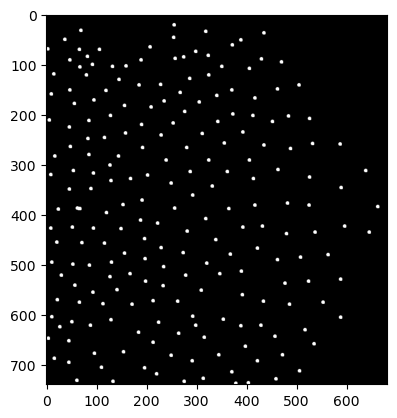

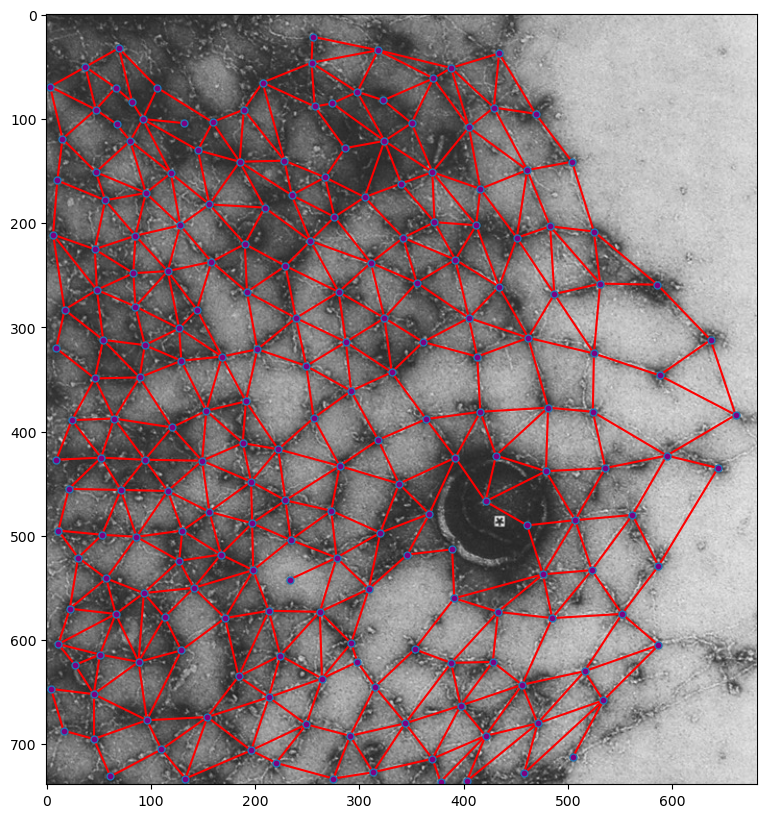

In [14]:
em = cv2.imread("../data/em/2.png", -1)
gt = cv2.imread("../data/em/2_marked.png", -1)
plt.imshow(gt[:,:,2]-gt[:,:,1])
marker = gt[:,:,2]-gt[:,:,1]
contours = cv2.findContours(marker.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]
contour_centers = np.zeros([len(contours)-1,2])
for i in range(len(contours)-1):
    contour_centers[i] = contours[i+1].reshape([-1,2]).mean(axis=0)

vxs=contour_centers
n_vx = len(vxs)
gt_sp = cv2.imread("../data/em/2_marked_final.png", -1)
plt.figure(figsize=[10,10])
plt.imshow(em)
marker_sp=gt_sp[:,:,1]-gt_sp[:,:,0]
links = np.zeros([n_vx, n_vx])
close_mid=np.zeros(marker_sp.T.shape)
for i in range(n_vx):
    close_mid[vxs[i][0].astype(int),vxs[i][1].astype(int)] = 1

close_mid = fftconvolve(close_mid, np.ones([10,10]), mode='same')

#plt.figure(figsize=[10,10])
#plt.imshow(close_mid.T)
dist = distance_matrix(vxs, vxs)
for i in range(n_vx):
    for j in range(i+1,n_vx):
        if dist[i][j] < 110:
            if sum_line_cnct(marker_sp.T, vxs[i].astype(int),vxs[j].astype(int))>=dist[i][j]*0.7:
                if sum_line_cnt(close_mid, vxs[i].astype(int),vxs[j].astype(int))[0] <3:
                    links[i,j]=links[j][i]=1
                    plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color="r")
                #else:
                #    plt.plot([vxs[i][0],vxs[j+1][0]],[vxs[i][1],vxs[j+1][1]], color="b")

plt.plot(
    contour_centers[:, 0],
    contour_centers[:, 1],
    ".",
    markerfacecolor="purple",
    markersize=10,
    )

In [15]:
[x for x in vxs if x[0]>600 and x[1]>0]

[array([644., 435.]), array([661., 384.]), array([637., 312.])]

In [ ]:
link_list = convertMatrix2List(links)
vxs_dc = []
for link in link_list:
    vxs_dc.append((vxs[link[0]]+vxs[link[1]])/2)    
vxs_dc = np.array(vxs_dc)

In [ ]:
plotAllStatsForVXS(vxs,lmax=150,dr=10, n=10,title="Red blood cell")

In [ ]:
plt.figure(figsize=[10,10])

plt.imshow(em)
plt.plot(
    vxs_dc[:,0],
    vxs_dc[:,1],
    ".",
    markerfacecolor="purple",
    markersize=10,
    )
ax = plt.gca()
for vx_dc in vxs_dc:
    size=30
    circle = plt.Circle((vx_dc[0], vx_dc[1]), size, color="r", fill=False)
    ax.add_artist(circle)

In [ ]:
plt.figure(figsize=[10,10])

plt.imshow(em)
plt.plot(
    vxs_dc[:,0],
    vxs_dc[:,1],
    ".",
    markerfacecolor="purple",
    markersize=10,
    )
ax = plt.gca()
for vx_dc in vxs_dc:
    size=30
    circle = plt.Circle((vx_dc[0], vx_dc[1]), size, color="r", fill=False)
    ax.add_artist(circle)

In [ ]:
plt.figure(figsize=[10,10])

plt.imshow(em)
tri = Delaunay(vxs_dc)
thre = 30
small_tri = [ x for x in tri.simplices if np.linalg.norm(vxs_dc[x[0]]-vxs_dc[x[1]])<= thre and np.linalg.norm(vxs_dc[x[2]]-vxs_dc[x[1]])<= thre and np.linalg.norm(vxs_dc[x[0]]-vxs_dc[x[2]])<= thre]

plt.triplot(vxs_dc[:,0], vxs_dc[:,1], small_tri)


In [ ]:
# length short to long, connect follow delaunary criteria, but only one triangle permitted
plt.figure(figsize=[10,10])

plt.imshow(em)
tri = Delaunay(vxs_dc)
thre = 30
small_tri = [ x for x in tri.simplices if np.linalg.norm(vxs_dc[x[0]]-vxs_dc[x[1]])<= thre and np.linalg.norm(vxs_dc[x[2]]-vxs_dc[x[1]])<= thre and np.linalg.norm(vxs_dc[x[0]]-vxs_dc[x[2]])<= thre]

plt.triplot(vxs_dc[:,0], vxs_dc[:,1], small_tri)

def max_len(tri):
    a = np.linalg.norm(vxs_dc[tri[0]]-vxs_dc[tri[1]])
    b = np.linalg.norm(vxs_dc[tri[2]]-vxs_dc[tri[1]])
    c = np.linalg.norm(vxs_dc[tri[0]]-vxs_dc[tri[2]])
    if a > b:
        tmax = a
    else:
        tmax = b
    if tmax > c:
        return tmax
    else:
        return c

x = sorted(tri.simplices, key=max_len)

In [ ]:
n_vx = len(vxs_dc)
st_link = np.zeros([n_vx, n_vx])
y = []
thre = 55
for st in x:
    if max_len(st) > thre:
        break
    if st_link[st[0],st[1]]==1 or st_link[st[2],st[1]]==1 or st_link[st[0],st[2]]==1:
        continue
    if np.sum(st_link[st[0],:])==4 or np.sum(st_link[st[1],:])==4 or np.sum(st_link[st[2],:])==4:
        continue
    else:
        st_link[st[0], st[1]]=st_link[st[1], st[0]]=1
        st_link[st[2], st[1]]=st_link[st[1], st[2]]=1
        st_link[st[0], st[2]]=st_link[st[2], st[0]]=1
        y.append(st)

# each vertices at most 2 triangle

# error 2 is triable too

In [ ]:
plt.figure(figsize=[10,10])
plt.imshow(em)
plt.triplot(vxs_dc[:,0], vxs_dc[:,1], y)


In [ ]:
# Find circlecenters
circums = [ getTrianglesCircumcenter(stri) for stri in small_tri ]

In [ ]:
# use small triangle to find nodes

tri = Delaunay(vxs_dc)
thre = 30
small_tri = [ x for x in tri.simplices if np.linalg.norm(vxs_dc[x[0]]-vxs_dc[x[1]])<= thre and np.linalg.norm(vxs_dc[x[2]]-vxs_dc[x[1]])<= thre and np.linalg.norm(vxs_dc[x[0]]-vxs_dc[x[2]])<= thre]
large_tri = getLargeTri(vxs_dc, small_tri)



In [ ]:
# find outcenter for triangles

In [ ]:
dist_distribution=[]
for i in range(n_vx):
    for j in range(i+1, n_vx):
        if links[i][j]==1:
            dist_distribution.append(np.linalg.norm(points[i]-points[j]))

In [ ]:
plt.hist(dist_distribution, bins=20)
plt.hist(fp, bins=20)
plt.title("Histogram of Spectrin Length Distribution")
plt.xlabel("Lengths (Pixels)")
plt.ylabel("Counts")
plt.legend(["True distribution","False distribution"])

In [ ]:
links_distribution=np.sum(links,0)
plt.hist(links_distribution, bins=7)
plt.title("Histogram of Branches per Junction")
plt.xlabel("Junction Numbers")
plt.ylabel("Counts")

In [ ]:
np.unique(links_distribution)

In [5]:

def sum_line_cnt(img, p0, p1):
    """Generate pixel coordinates of the line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    pixels = []
    cnt = 0
    flag = 0
    x0 = p0[0]
    y0 = p0[1]
    x1 = p1[0]
    y1 = p1[1]

    # Determine differences and steps
    #print(x0, x1, y0, y1)
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy

    while True:
        pixels.append((x0, y0))  # Add the current pixel to the list
        if np.around(img[x0][y0])==1 and flag==0:
            cnt+=1
            flag=1
        elif np.around(img[x0][y0])==0 and flag==1:
            flag=0
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 >= dy:  # error accumulated exceeds the threshold
            err += dy
            x0 += sx
        if e2 <= dx:  # error accumulated exceeds the threshold
            err += dx
            y0 += sy

    return cnt, pixels

def sum_line_cnct(img, p0, p1):
    """Generate pixel coordinates of the line from (x0, y0) to (x1, y1) using Bresenham's algorithm."""
    #pixels = []
    max_sum = 0
    sum = 0
    x0 = p0[0]
    y0 = p0[1]
    x1 = p1[0]
    y1 = p1[1]

    # Determine differences and steps
    #print(x0, x1, y0, y1)
    dx = abs(x1 - x0)
    dy = -abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx + dy
    
    while True:
        #pixels.append((x0, y0))  # Add the current pixel to the list
        if img[x0][y0]>0:
            sum += img[x0][y0]>0
        else:
            if max_sum < sum:
                max_sum = sum
            sum = 0
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 >= dy:  # error accumulated exceeds the threshold
            err += dy
            x0 += sx
        if e2 <= dx:  # error accumulated exceeds the threshold
            err += dx
            y0 += sy

    
    if max_sum < sum:
        max_sum = sum
    return max_sum


In [ ]:

tri = Delaunay(vxs)

points=vxs
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)

plt.imshow(em)
#plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1],'o')
perf1 = []
thres = [x * 5 for x in range(7, 25)]
thres = [100]
for thre in thres:
    small_tri = [ x for x in tri.simplices if np.linalg.norm(points[x[0]]-points[x[1]])<= thre and np.linalg.norm(points[x[2]]-points[x[1]])<= thre and np.linalg.norm(points[x[0]]-points[x[2]])<= thre]
    link_dl = np.zeros([n_vx, n_vx])
    # for x in tri.simplices:
    #     if np.linalg.norm(points[x[0]]-points[x[1]])<= thre:
    #         link_dl[x[0]][x[1]]=link_dl[x[1]][x[0]]=1
    #     if np.linalg.norm(points[x[0]]-points[x[2]])<= thre:
    #         link_dl[x[0]][x[2]]=link_dl[x[2]][x[0]]=1
    #     if np.linalg.norm(points[x[0]]-points[x[1]])<= thre:
    #         link_dl[x[1]][x[2]]=link_dl[x[2]][x[1]]=1

    for x in small_tri:
        link_dl[x[0]][x[1]]=link_dl[x[1]][x[0]]=link_dl[x[0]][x[2]]=link_dl[x[2]][x[0]]=link_dl[x[1]][x[2]]=link_dl[x[2]][x[1]]=1
    perf1.append(performance(link_dl, links))
    plt.triplot(points[:,0], points[:,1], small_tri, c="g")
    ax.set_aspect('equal', adjustable='box')

fp=[]
for i in range(n_vx):
    for j in range(i+1, n_vx):
        if link_dl[i][j]==1 and links[i][j]==0:
            plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color="r")
            fp.append(dist[i][j])
        elif link_dl[i][j]==0 and links[i][j]==1:
            plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], '--', color="r")

colors=[plt.cm.Accent(i) for i in np.linspace(0, 1, 8)]
for i in range(n_vx):
    plt.plot(points[i,0], points[i,1],'o',c=colors[int(links_distribution[i])])



In [ ]:
links_distribution[i]

In [ ]:
plt.hist(fp,bins=20)

In [ ]:

ax=plt.gca()
ax.set_prop_cycle('color',[plt.cm.Accent(i) for i in np.linspace(0, 1, 3)])
plt.plot(thres, perf)
plt.plot(thres, perf1,'--')

plt.legend(["Accuracy", "Precision", "Recall", "Accuracy for triangles", "Precision for triangles", "Recall for triangles"])
#plt.yscale('log',base=10) 
plt.xlabel("Upper bound(pixels)")
plt.title("Effect of upper bound changes to the Delaunary result preformance")

In [ ]:
link_dl = np.zeros([n_vx, n_vx])
for x in small_tri:
    link_dl[x[0]][x[1]]=link_dl[x[0]][x[2]]=link_dl[x[1]][x[0]]=link_dl[x[1]][x[2]]=link_dl[x[2]][x[1]]=link_dl[x[2]][x[0]]=1
performance(link_dl, links)

In [ ]:
from scipy.spatial import Delaunay
tri = Delaunay(vxs)

points=vxs
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)

links_att = np.zeros([n_vx, n_vx])


In [ ]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)



perf_th = []
plt.figure(figsize=[10,10])
plt.imshow(em)
#ks=[ x for x in range(1,8)]
ks=[x+1 for x in range(10)]
for k in ks:
    s_dist=np.argsort(dist,axis=1)
    nearest_k = s_dist[:,:k]
    link_th = np.zeros([n_vx, n_vx])
    for i in range(n_vx):
        cnt=0
        for j in range(k):
            jk = nearest_k[i][j]
            flag=0
            if dist[i][jk] < 110:
                if sum_line_cnt(close_mid, vxs[i].astype(int),vxs[jk].astype(int))[0] <3:
                    link_th[i][jk]=link_th[jk][i]=1
                    plt.plot([vxs[i][0],vxs[jk][0]],[vxs[i][1],vxs[jk][1]], color="g")
    perf_th.append(performance(link_th, links))
    # for i in range(n_vx):
    #     for j in range(i+1, n_vx):
    #         if link_th[i][j]==1 and links[i][j]==0:
    #             plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color="r")
    #         elif link_th[i][j]==0 and links[i][j]==1:
    #             plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], '--', color="r")


for i in range(n_vx):
    for j in range(k):
        jk = nearest_k[i][j]
        if link_th[i][j]==0
    if intersect(vxs[lines[0]],vxs[lines[1]],vxs[i],vxs[jk]):
    flag=1
    break


In [ ]:

ax=plt.gca()
ax.set_prop_cycle('color',[plt.cm.Accent(i) for i in np.linspace(0, 1, 3)])
plt.plot(ks, perf_th)

plt.legend(["Accuracy", "Precision", "Recall"])
#plt.yscale('log',base=10) 
plt.xlabel("The K shortest")
plt.title("Effect of K  to the K nearest neighbour connection preformance")

In [ ]:
perf_th[7:]

In [ ]:

import math
def angle_of_line(xy0, xy1):
    xy=xy1-xy0
    return math.atan2(-xy[1], xy[0])

def plotBalance(links, vxs, plot=1, len_unstretched=50):
    n_vx=len(vxs)
    balance = [[0,0] for x in range(n_vx)]
    for i in range(n_vx):
        for j in range(i+1,n_vx):
            if links[i][j] == 1:
                tmp_dist = np.linalg.norm(vxs[i]-vxs[j])
                tmp_angle=angle_of_line(vxs[i],vxs[j])
                if tmp_dist > len_unstretched:
                    balance[i][0]+=(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                    balance[i][1]+=(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                if plot == 1:
                    plt.plot([vxs[i][0],vxs[j][0]], [vxs[i][1],vxs[j][1]], color="g")#cmap((t_dist-thre[0])/(thre[1]-thre[0])))
    colors=[plt.cm.cool(i) for i in np.linspace(0, 1, 10)]
    total_balance = [ x[0]**2 + x[1]**2 for x in balance ]
    t_balance = total_balance/np.max(total_balance)
    if plot == 1:
        for i in range(n_vx):
            plt.plot(vxs[i,0],vxs[i,1],".",markerfacecolor=plt.cm.cool(t_balance[i]), markeredgecolor=plt.cm.cool(t_balance[i]), markersize=10)
        ax = plt.gca()
        ax.set_aspect('equal', adjustable='box')
    return balance, total_balance

In [ ]:
b_t,_=plotBalance(links, vxs)

In [ ]:
b_t,_=plotBalance(link_rd, vxs)

In [ ]:
performance(link_dl, links)

In [ ]:
len_unstretched = 50
#b_n=plotBalance(link_dl, vxs)
def reduceLink(links, vxs, len_unstretched=50):
    balance, total_balance = plotBalance(links, vxs, 0, len_unstretched)
    n_links = links.copy()
    while True:
        # generate the improvement matrix
        improve_links=np.zeros(links.shape)
        for i in range(n_vx):
            # can be optimized by store max_improve and only the max_improve point
            for j in range(i+1, n_vx):
                if links[i][j]==1:
                    tmp_dist = np.linalg.norm(vxs[i]-vxs[j])
                    tmp_angle=angle_of_line(vxs[i],vxs[j])
                    if tmp_dist > len_unstretched:
                        tmp_b0=balance[i][0]-(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                        tmp_b1=balance[i][1]-(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                        tmp_b2=balance[j][0]-(tmp_dist-len_unstretched)*math.cos(tmp_angle)
                        tmp_b3=balance[j][1]-(tmp_dist-len_unstretched)*math.sin(tmp_angle)
                        tmp_improve = total_balance[i]+total_balance[j] - tmp_b0**2+tmp_b1**2+tmp_b2**2+tmp_b3**2
                        if tmp_improve > 0:
                            improve_links[i][j]=tmp_improve
        affected_vxs=np.zeros(vxs.shape)
        
    return(n_links)

# or start from the most unbalanced point

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

def plotComparison(links1, links2, vxs, colors=[plt.cm.Accent(i) for i in np.linspace(0, 1, 3)]):
    # common links in green
    # links1 only in red
    # links2 only in dashed red
    plt.figure(figsize=[10,10])
    n_vx = len(links1)
    for i in range(n_vx):
        for j in range(i+1, n_vx):
            if links1[i][j]==1 and links2[i][j]==1:
                plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color=colors[0])
            elif links1[i][j]==1 and links2[i][j]==0:
                plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color=colors[1])
            elif links1[i][j]==0 and links2[i][j]==1:
                plt.plot([vxs[i][0],vxs[j][0]],[vxs[i][1],vxs[j][1]], color=colors[2])

    b1 = plotBalance(links1, vxs, plot=0, len_unstretched=50)[1]
    b2 = plotBalance(links2, vxs, plot=0, len_unstretched=50)[1]

    for i in range(n_vx):
        if b1[i] > b2[i]:
            plt.plot(points[i,0], points[i,1],'o',c=colors[2])
        elif b1[i] < b2[i]:
            plt.plot(points[i,0], points[i,1],'o',c=colors[1])
        else:
            plt.plot(points[i,0], points[i,1],'o',c=colors[0])

    handles, labels = plt.gca().get_legend_handles_labels()
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    line0 = Line2D([0], [0], label='Common', color=colors[0])
    line1 = Line2D([0], [0], label='Links1 only', color=colors[1])
    line2 = Line2D([0], [0], label='Links2 only', color=colors[2])
    point0 = Line2D([0], [0], label='Common Vertex', marker='o', markersize=10, 
            markeredgecolor=colors[0], markerfacecolor=colors[0], linestyle='')
    point1 = Line2D([0], [0], label='Links1 Better Vertex', marker='o', markersize=10, 
            markeredgecolor=colors[1], markerfacecolor=colors[1], linestyle='')
    point2 = Line2D([0], [0], label='Links2 Better Vertex', marker='o', markersize=10, 
            markeredgecolor=colors[2], markerfacecolor=colors[2], linestyle='')

    # add manual symbols to auto legend
    handles.extend([line0, line1, line2, point0, point1, point2])
    plt.legend(handles=handles)

In [ ]:
plotComparison(links, link_dl, vxs)

In [ ]:
plotComparison(link_rd, links, vxs)

In [ ]:
#(0.9942022714981071, 0.8013355592654424, 0.9696969696969697)
link_rd=reduceLink(link_dl, vxs, len_unstretched=50)
performance(link_rd, links)

In [ ]:
x=plotBalance(link_rd, vxs)

In [ ]:
np.sum(np.array(x).flatten())

In [ ]:
x=plotBalance(link_dl, vxs)

In [ ]:
plt.imshow(img[regions[2]:regions[3],regions[0]:regions[1]])

# Run on a lot of images

In [ ]:
img = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/adducin_647_1.png", -1)
loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0001_list_COR.txt"
regions=[1000,1500,1000,1500]
img,vxs = lmax_loc(loc_file,regions,img[regions[2]:regions[3],regions[0]:regions[1]])
links=generateLinks(vxs, img, thre=220/16)
link_list = convertMatrix2List(links)
tri_list = getTrianglesFromList(link_list)
h1 = HeatmapOfTris(vxs, tri_list)
h2 = HeatmapOfConnects(vxs, links)
print("Average junction connections:", np.mean(np.sum(links, 0)))
at = AreaCoveredByTriangles(tri_list, vxs)
ac = AreaOfCell(img)
print("Coverage percentage of connected Triangles:", 100*at/ac, "%")
plt.figure(figsize=[10,10])
plt.imshow(h1.T)
plt.figure(figsize=[10,10])
plt.imshow(h2.T)
plt.figure(figsize=[10,10])
plt.plot(h1.flatten(), h2.flatten(),'.')
plt.xlabel("Triangle Numbers")
plt.ylabel("Average Junction Connections")
plt.title("The correlation is: "+str(np.corrcoef(h1.flatten(),h2.flatten())[0][1]))

In [ ]:
# img = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/adducin_647_1.png", -1)
# loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0001_list_COR.txt"
# regions=[1000,1500,1000,1500]
img = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/adducin_647_2.png", -1)
loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0002_list_COR.txt"
regions=[564,564+681,696,696+687]
img,vxs = lmax_loc(loc_file,regions,img[regions[2]:regions[3],regions[0]:regions[1]])
links=generateLinks(vxs, img, thre=220/16)
link_list = convertMatrix2List(links)
tri_list = getTrianglesFromList(link_list)
h1 = HeatmapOfTris(vxs, tri_list)
h2 = HeatmapOfConnects(vxs, links)
print("Average junction connections:", np.mean(np.sum(links, 0)))
at = AreaCoveredByTriangles(tri_list, vxs)
ac = AreaOfCell(img)
print("Coverage percentage of connected Triangles:", 100*at/ac, "%")
plt.figure(figsize=[10,10])
plt.imshow(h1.T)
plt.figure(figsize=[10,10])
plt.imshow(h2.T)
plt.figure(figsize=[10,10])
plt.plot(h1.flatten(), h2.flatten(),'.')
plt.xlabel("Triangle Numbers")
plt.ylabel("Average Junction Connections")
plt.title("The correlation is: "+str(np.corrcoef(h1.flatten(),h2.flatten())[0][1]))

In [ ]:
img = cv2.imread("../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/adducin_647_5.png", -1)
loc_file="../data/rendered/Tcell/inactivated/AF647_adducin CF597R_b2spec/STORM-AF647_0005_list_COR.txt"
regions=[687,687+825,792,792+777]
img,vxs = lmax_loc(loc_file,regions,img[regions[2]:regions[3],regions[0]:regions[1]])
cell_mask = AreaOfCell(img)[0]
vxs = np.array([x for x in vxs if cell_mask[int(x[1])][int(x[0])]>0])
links=generateLinks(vxs, img, thre=220/16)
link_list = convertMatrix2List(links)
tri_list = getTrianglesFromList(link_list)
h1 = HeatmapOfTris(vxs, tri_list)
h2 = HeatmapOfConnects(vxs, links)
print("Average junction connections:", np.mean(np.sum(links, 0)))
at = AreaCoveredByTriangles(tri_list, vxs)
ac = AreaOfCell(img)[1]
print("Coverage percentage of connected Triangles:", 100*at/ac, "%")
plt.figure(figsize=[10,10])
plt.imshow(h1.T)
plt.figure(figsize=[10,10])
plt.imshow(h2.T)
plt.figure(figsize=[10,10])
plt.plot(h1.flatten(), h2.flatten(),'.')
plt.xlabel("Triangle Numbers")
plt.ylabel("Average Junction Connections")
plt.title("The correlation is: "+str(np.corrcoef(h1.flatten(),h2.flatten())[0][1]))

In [ ]:
img = cv2.imread("../data/rendered/soma/1226_5.png", -1)
loc_file="../data/rendered/soma/1226_5.txt"
regions=[996,996+855,717,717+744]
img,vxs = lmax_loc(loc_file,regions,img[regions[2]:regions[3],regions[0]:regions[1]])
cell_mask = AreaOfCell(img)[0]
vxs = np.array([x for x in vxs if cell_mask[int(x[1])][int(x[0])]>0])
links=generateLinks(vxs, img, thre=220/16)
link_list = convertMatrix2List(links)
tri_list = getTrianglesFromList(link_list)
h1 = HeatmapOfTris(vxs, tri_list)
h2 = HeatmapOfConnects(vxs, links)
print("Average junction connections:", np.mean(np.sum(links, 0)))
at = AreaCoveredByTriangles(tri_list, vxs)
ac = AreaOfCell(img)[1]
print("Coverage percentage of connected Triangles:", 100*at/ac, "%")
plt.figure(figsize=[10,10])
plt.imshow(h1.T)
plt.figure(figsize=[10,10])
plt.imshow(h2.T)
plt.figure(figsize=[10,10])
plt.plot(h1.flatten(), h2.flatten(),'.')
plt.xlabel("Triangle Numbers")
plt.ylabel("Average Junction Connections")
plt.title("The correlation is: "+str(np.corrcoef(h1.flatten(),h2.flatten())[0][1]))

In [ ]:
img = cv2.imread("../data/rendered/soma/1226_9.png", -1)
loc_file="../data/rendered/soma/1226_9.txt"
regions=[741,741+1188,669,669+843]
img,vxs = lmax_loc(loc_file,regions,img[regions[2]:regions[3],regions[0]:regions[1]])
cell_mask = AreaOfCell(img)[0]
vxs = np.array([x for x in vxs if cell_mask[int(x[1])][int(x[0])]>0])
links=generateLinks(vxs, img, thre=220/16)
link_list = convertMatrix2List(links)
tri_list = getTrianglesFromList(link_list)
h1 = HeatmapOfTris(vxs, tri_list)
h2 = HeatmapOfConnects(vxs, links)
print("Average junction connections:", np.mean(np.sum(links, 0)))
at = AreaCoveredByTriangles(tri_list, vxs)
ac = AreaOfCell(img)[1]
print("Coverage percentage of connected Triangles:", 100*at/ac, "%")
plt.figure(figsize=[10,10])
plt.imshow(h1.T)
plt.figure(figsize=[10,10])
plt.imshow(h2.T)
plt.figure(figsize=[10,10])
plt.plot(h1.flatten(), h2.flatten(),'.')
plt.xlabel("Triangle Numbers")
plt.ylabel("Average Junction Connections")
plt.title("The correlation is: "+str(np.corrcoef(h1.flatten(),h2.flatten())[0][1]))

In [ ]:
plt.imshow(autocontrast(h1.T))
plt.figure()
plt.imshow(autocontrast(h2.T))

In [ ]:
plt.hist(h1.flatten())

In [ ]:
plt.hist(h2.flatten())

In [ ]:
vxs

In [ ]:
smlm=pd.read_table(loc_file,header=0)
test=smlm[["Xc","Yc","Zc"]]
img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)

xc=test["Xc"].tolist()
yc=test["Yc"].tolist()
xc=np.array([ int(x*10-regions[0]) for x in xc]).astype(np.int32)-5
yc=np.array([ int(x*10-regions[2]) for x in yc]).astype(np.int32)-5
img=grid2D(img,xc,yc,regions[1]-regions[0], regions[3]-regions[2],len(xc))

In [ ]:
np.min(blur)

In [ ]:
blur=cv2.blur(np.array(img).T,(4,4))

# Summary the link results

# Random Forest Attempts

In [ ]:
d = {'vx1_x': np.repeat([vxs[x][0] for x in range(n_vx)], n_vx), 'vx1_y': np.repeat([vxs[x][1] for x in range(n_vx)], n_vx), 'vx2_x': np.tile([vxs[x][0] for x in range(n_vx)], n_vx), 'vx2_y': np.tile([vxs[x][1] for x in range(n_vx)], n_vx),'length': np.array(dist).flatten()}
X = pd.DataFrame(data=d)

In [ ]:
link = {'connect': np.array(links).flatten()}
y = np.array(links).flatten()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=1)
clf.fit(X, y)

In [ ]:
a=clf.predict(X)

# Play around with pointpats

In [ ]:
pp = pointpats.PointPattern(vxs)
print(pp.summary())
pp.plot(window= True, title= "Point pattern")

In [ ]:
g_test.support


In [ ]:
g_test = pointpats.g_test(vxs, support=10,  keep_simulations=True)

# grab the middle 95% of simulations using numpy:
middle_95pct = np.percentile(g_test.simulations, q=(2.5, 97.5), axis=0)
# use the fill_between function to color between the 2.5% and 97.5% envelope
plt.fill_between(g_test.support, *middle_95pct, 
                 color='lightgrey', label='simulated')

# plot the line for the observed value of G(d)
plt.plot(g_test.support, g_test.statistic, 
         color='orangered', label='observed')
# and plot the support points depending on whether their p-value is smaller than .05
plt.scatter(g_test.support, g_test.statistic, 
            cmap='viridis', c=g_test.pvalue < .01)
plt.legend()
plt.xlabel('Distance')
plt.ylabel('G Function')
plt.title('G Function Plot')
plt.show()

In [ ]:
k_test = pointpats.k_test(vxs*16, keep_simulations=True)
plt.plot(k_test.support, k_test.simulations.T, color='k', alpha=.01)
plt.plot(k_test.support, k_test.statistic, color='orangered')

plt.scatter(k_test.support, k_test.statistic, 
            cmap='viridis', c=k_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('K Function')
plt.title('K Function Plot')
plt.show()

In [ ]:
#link_list = convertMatrix2List(links)
#tri_list = getTrianglesFromList(link_list)
#tri_cents = getTrianglesCentroid(tri_list, vxs)
#k_test = pointpats.k_test(np.array(tri_cents)*16, keep_simulations=True,n_simulations=10)
plot_ltest(np.array(tri_cents)*16, support=(1,300,20), title="Triangle Center")

In [ ]:
plot_ltest(np.array(vxs)*16, support=(1,300,20), title="Junctions", n_simulations=100)

In [ ]:
plot_ktest(np.array(vxs)*16, support=(1,300,20), title="Junctions")

In [ ]:
bin_centers, rdf = compute_rdf(vxs, max_distance, num_bins, box_length)

plt.figure(figsize=(8, 5))
plt.plot(bin_centers, rdf)
plt.xlabel('Distance')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.grid(True)
plt.show()